In [1]:
import os
import shutil
import warnings

import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from sklearn import metrics, preprocessing
from MulticoreTSNE import MulticoreTSNE as TSNE

from train import create_net, create_supcon
from utils.eval import eval_net, eval_supcon
from utils.datasets import AortaDataset3D

warnings.filterwarnings("ignore")
np.random.seed(63910)
torch.manual_seed(53152)
torch.cuda.manual_seed_all(7987)
torch.backends.cudnn.deterministic = True

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

In [3]:
transform = T.Compose([
    T.Resize(81), # 缩放图片(Image)，保持长宽比不变，最短边为img_size像素
    T.CenterCrop(81), # 从图片中间切出img_size*img_size的图片
    T.ToTensor(), # 将图片(Image)转成Tensor，归一化至[0, 1]
])

In [4]:
val = ImageFolder('/nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/', transform=transform, loader=lambda path: Image.open(path))
val_loader = DataLoader(val, batch_size=100, shuffle=True, num_workers=8, pin_memory=True, drop_last=False)

In [5]:
# net1 = create_net(device, 1, 3, 'details/checkpoints/CrossEntropy/11-06_12:19:06/Net_best.pth', entire=True)
# net2 = create_net(device, 1, 1, 'details/checkpoints/CrossEntropy/11-06_12:22:36/Net_epoch49.pth', entire=True)
net1 = create_net(device, 34, 1, 3, 'details/checkpoints/CrossEntropy/11-11_21:46:30/Net_best.pth', entire=True)
net2 = create_net(device, 34, 1, 1, 'details/checkpoints/CrossEntropy/11-11_21:52:03/Net_best.pth', entire=True)
net1.eval()
net2.eval()

[INFO]: **********************************************************************
Network: ResNet_34
	1 input channels
	3 output channels (classes)
	3D model: False

[INFO]: Model loaded from details/checkpoints/CrossEntropy/11-11_21:46:30/Net_best.pth
[INFO]: **********************************************************************
Network: ResNet_34
	1 input channels
	1 output channels (classes)
	3D model: False

[INFO]: Model loaded from details/checkpoints/CrossEntropy/11-11_21:52:03/Net_best.pth


ResNet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [8]:
num_val_batches = len(val_loader)  # the number of batch
n_val = 12434

true_list = []
pred_list = []

for imgs, true_categories in tqdm(val_loader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
    imgs = imgs.to(device=device, dtype=torch.float32)
    true_categories = true_categories.to(device=device, dtype=torch.long)
    true_list += true_categories.tolist()

    with torch.no_grad():
        categories_pred1 = net1(imgs)

    pred1 = torch.softmax(categories_pred1, dim=1)
    pred1 = pred1.argmax(dim=1)
    datas = imgs[pred1 == 1]
    
    with torch.no_grad():
        categories_pred2 = net2(datas)
        
    pred2 = torch.sigmoid(categories_pred2)
    pred2 = (pred2 > 0.5).long().squeeze(-1)
        
#     print(pred1)
#     print(pred2)
#     print(true_categories.shape[0])
#     print(datas.shape[0])
    
    pred1[pred1 == 2] = 3
    pred1[pred1 == 1] = pred2+1
    #print(pred1)
    
    pred_list.extend(pred1.tolist())
    


In [9]:
print(metrics.classification_report(true_list, pred_list, digits=4))

              precision    recall  f1-score   support

           0     0.9011    0.8980    0.8996      6522
           1     0.8034    0.8929    0.8458      4370
           2     0.7133    0.5239    0.6041      1149
           3     0.5966    0.3537    0.4441       393

    accuracy                         0.8445     12434
   macro avg     0.7536    0.6671    0.6984     12434
weighted avg     0.8398    0.8445    0.8390     12434



In [6]:
net = create_supcon(device, 34, 1, True, 'details/checkpoints/SupCon/11-12_04:11:21/Net_last.pth')

[INFO]: **********************************************************************
Network: SupConResNet+resnet34
	1 input channels
	3D model: False

[INFO]: Model loaded from details/checkpoints/SupCon/11-12_04:11:21/Net_last.pth


(0.5555128821076771,
 'details/checkpoints/CrossEntropy/11-12_12:04:20/TSNE.png')

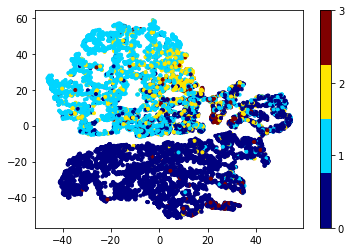

In [7]:
eval_supcon(net, val_loader, 12434, device, 4, True, 'details/checkpoints/CrossEntropy/11-12_12:04:20')

In [9]:
net = create_net(device, 34, 1, 4, 'details/checkpoints/CrossEntropy/11-10_17:56:10/Net_best.pth', entire=True)

[INFO]: **********************************************************************
Network: ResNet_34
	1 input channels
	4 output channels (classes)
	3D model: False

[INFO]: Model loaded from details/checkpoints/CrossEntropy/11-10_17:56:10/Net_best.pth


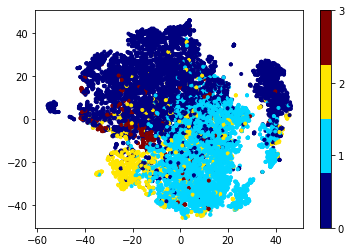

In [10]:
repr_list = []
label_list = []
def get_repr_vector(module, input, output):
    repr_list.append(input[0])
handle = net.fc.register_forward_hook(get_repr_vector)
    
for imgs, true_categories in tqdm(val_loader, total=len(val_loader), desc='Validation round', unit='batch', leave=False):
    imgs = imgs.to(device=device, dtype=torch.float32)
    true_categories = true_categories.to(device=device, dtype=torch.long)
    label_list.append(true_categories)
    with torch.no_grad():
        net(imgs)
        
handle.remove()
reprs = torch.cat(repr_list, dim=0).cpu().numpy()
labels = torch.cat(label_list, dim=0).cpu().numpy()
reprs_tsne = TSNE(n_jobs=8).fit_transform(reprs)
vis_x = reprs_tsne[:, 0]
vis_y = reprs_tsne[:, 1]
plt.scatter(vis_x, vis_y, c=labels, cmap=plt.cm.get_cmap("jet", 4), marker='.')
plt.colorbar(ticks=range(4))
plt.show()